# Setup

In [1]:
import warnings; warnings.simplefilter('ignore')
# set this to your working directory
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')
df=df.reset_index(drop=True)
df = df.assign(author_id=(df['authorship']).astype('category').cat.codes)
df = df[pd.notnull(df['authorship'])] # drop cases without an author
import numpy as np
vocab = pd.read_pickle('vocab.pkl')
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [2]:
df.shape

(768, 13)

# Entity Embeddings

In [3]:
# make judge dummy variables
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
J = encoder.fit_transform(df['author_id'].astype(str))
num_judges = max(J)+1
Y = df['x_republican'] > 0
Y2 = df['log_cite_count']

In [4]:
J[:10]

array([ 3, 10,  5,  4,  4,  9,  1,  3,  2,  3])

In [5]:
# set up DNN
from keras.models import Sequential
from keras.layers import Dense, Embedding, Flatten

model = Sequential()
model.add(Embedding(num_judges, # number of categories
                    2, # dimensions of embedding
                    input_length=1)) 
model.add(Flatten()) # needed after Embedding
model.add(Dense(2))
model.add(Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

#dot = model_to_dot(model,
#                   show_shapes=True,
#                   show_layer_names=False)
#SVG(dot.create(prog='dot', format='svg'))

Metal device set to: Apple M1 Pro


2022-03-28 15:54:26.980317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-28 15:54:26.980493: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 2)              22        
                                                                 
 flatten (Flatten)           (None, 2)                 0         
                                                                 
 dense (Dense)               (None, 2)                 6         
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________


2022-03-28 15:54:33.243699: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-28 15:54:33.530609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 1/20 [>.............................] - ETA: 0s - loss: 0.6638 - accuracy: 0.8750

2022-03-28 15:54:35.966200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 0s 13ms/step - loss: 0.6098 - accuracy: 0.7752 - val_loss: 0.5996 - val_accuracy: 0.7662


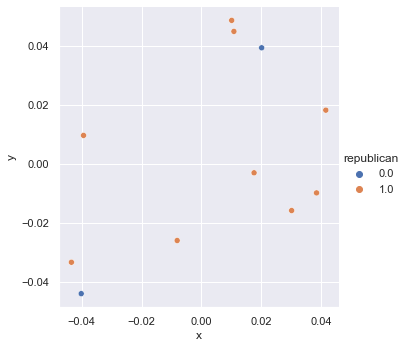

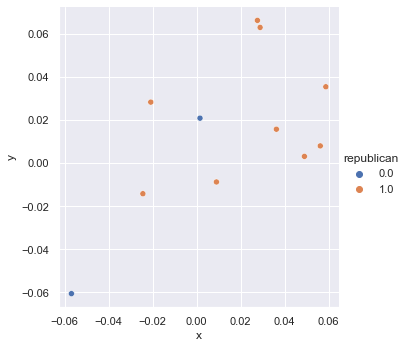

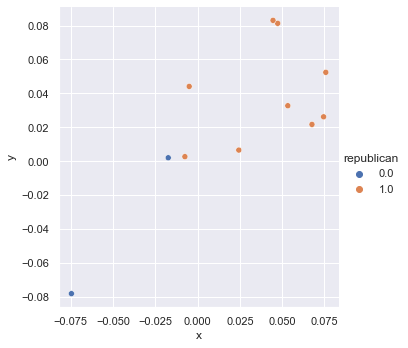

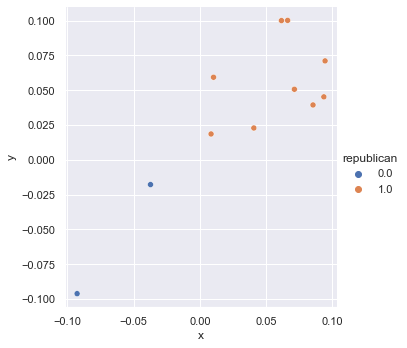

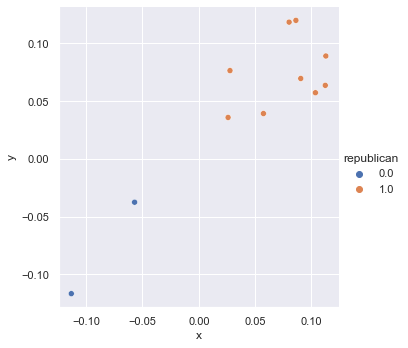

In [7]:
# Visualize the Judge Vectors
#!pip install ggplot
import seaborn as sns
sns.set_theme()

judge_cites = dict(Y.groupby(J).mean())
df2 = pd.DataFrame(J,columns=['authorship']).drop_duplicates().sort_values('authorship')
df2['republican'] = df2['authorship'].apply(lambda x: judge_cites[x])

for i in range(5):
    if i > 0:
        model.fit(J,Y,epochs=1, validation_split=.2)
    
    judge_vectors = model.layers[0].get_weights()[0]
    df2['x'] = judge_vectors[:,0]
    df2['y'] = judge_vectors[:,1]    

    sns.relplot( data=df2, x="x", y="y", hue='republican', kind='scatter')


# Word Embeddings

In [8]:
# convert documents to sequences of word indexes
from keras.preprocessing.text import Tokenizer
num_words = 200
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(df['opinion_text'])
sequences = tokenizer.texts_to_sequences(df['opinion_text'])
len(sequences)

768

In [9]:
sequences[0]

[138,
 1,
 111,
 2,
 1,
 19,
 4,
 22,
 4,
 48,
 10,
 195,
 40,
 14,
 8,
 46,
 21,
 11,
 185,
 3,
 4,
 76,
 108,
 5,
 34,
 1,
 24,
 37,
 1,
 100,
 2,
 21,
 49,
 29,
 50,
 1,
 10,
 1,
 76,
 20,
 4,
 47,
 109,
 24,
 37,
 94,
 2,
 82,
 35,
 72,
 4,
 159,
 6,
 4,
 48,
 27,
 34,
 4,
 100,
 2,
 47,
 69,
 12,
 10,
 4,
 2,
 34,
 29,
 19,
 69,
 1,
 100,
 10,
 195,
 49,
 72,
 1,
 19,
 38,
 1,
 18,
 64,
 24,
 1,
 72,
 1,
 108,
 10,
 4,
 10,
 6,
 31,
 29,
 149,
 2,
 6,
 1,
 2,
 140,
 7,
 1,
 2,
 19,
 158,
 28,
 1,
 2,
 1,
 19,
 16,
 1,
 10,
 1,
 2,
 1,
 24,
 21,
 76,
 28,
 4,
 100,
 2,
 72,
 1,
 108,
 10,
 4,
 10,
 1,
 149,
 2,
 1,
 99,
 6,
 135,
 32,
 2,
 7,
 2,
 6,
 1,
 53,
 41,
 62,
 19,
 10,
 1,
 62,
 2,
 24,
 1,
 19,
 2,
 82,
 10,
 1,
 170,
 54,
 5,
 149,
 24,
 30,
 117,
 4,
 49,
 7,
 66,
 72,
 42,
 10,
 11,
 4,
 19,
 2,
 120,
 2,
 100,
 91,
 12,
 4,
 10,
 4,
 2,
 1,
 108,
 6,
 37,
 59,
 104,
 35,
 10,
 24,
 120,
 2,
 1,
 19,
 2,
 100,
 30,
 29,
 149,
 73,
 49,
 7,
 120,
 1,
 2,
 1,
 149,
 24,

In [10]:
# represent data as numrows x maxlen matrix
from keras.preprocessing.sequence import pad_sequences
maxlen = max([len(sent) for sent in sequences]) 
maxlen

13971

In [11]:
X = pad_sequences(sequences, maxlen=maxlen)
X.shape

(768, 13971)

In [12]:
X[0]

array([ 0,  0,  0, ..., 20, 11, 81], dtype=int32)

In [13]:
X[0][maxlen-len(sequences[0]):]

array([138,   1, 111, ...,  20,  11,  81], dtype=int32)

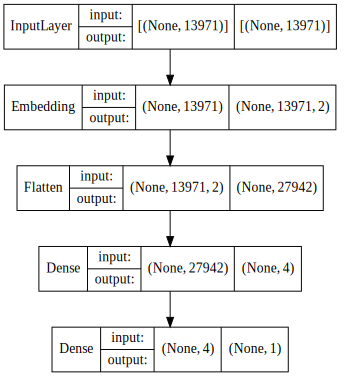

In [15]:
# Model setup
model = Sequential()
model.add(Embedding(num_words,
                    2,
                    input_length=maxlen)) # sequence length
model.add(Flatten()) # 86*2 = 172 dims
model.add(Dense(4))
model.add(Dense(1))
model.compile(optimizer='adam',loss='binary_crossentropy')
from IPython.display import HTML
style = "<style>svg{width:50% !important;height:50% !important;}</style>"
HTML(style)
dot = model_to_dot(model, show_shapes=True, show_layer_names=False,  dpi=70)
SVG(dot.create(prog='dot', format='svg'))

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 13971, 2)          400       
                                                                 
 flatten_2 (Flatten)         (None, 27942)             0         
                                                                 
 dense_4 (Dense)             (None, 4)                 111772    
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 112,177
Trainable params: 112,177
Non-trainable params: 0
_________________________________________________________________


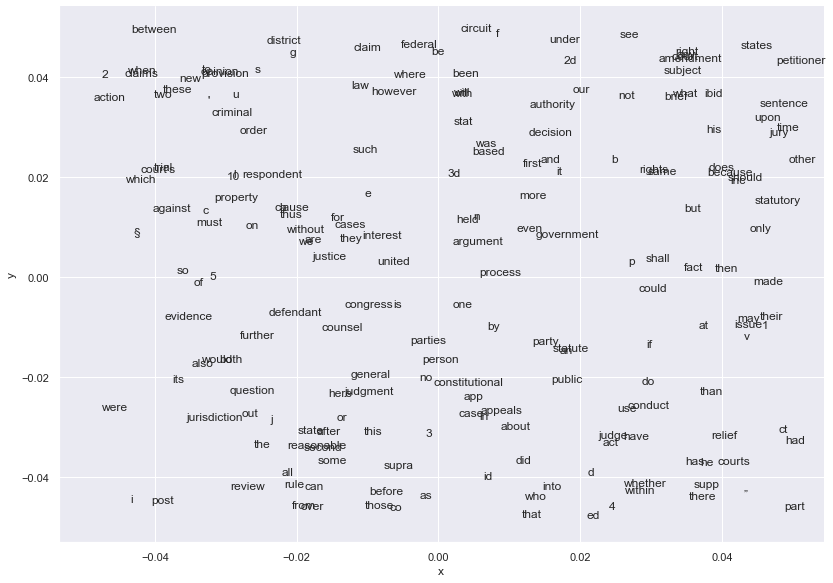

2022-03-28 15:54:55.167925: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 3s 26ms/step - loss: 3.5768 - val_loss: 3.5648


2022-03-28 15:54:57.941034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


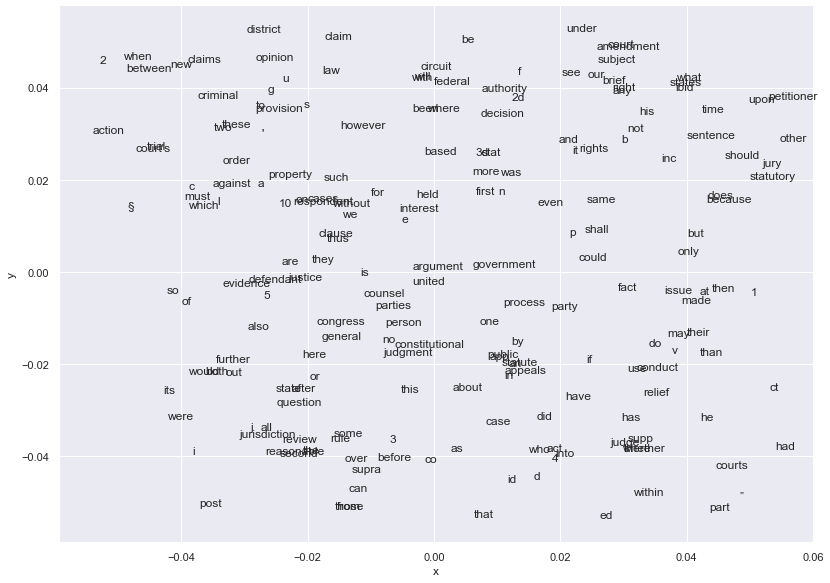

20/20 [==============================] - 0s 15ms/step - loss: 3.4307 - val_loss: 3.5648


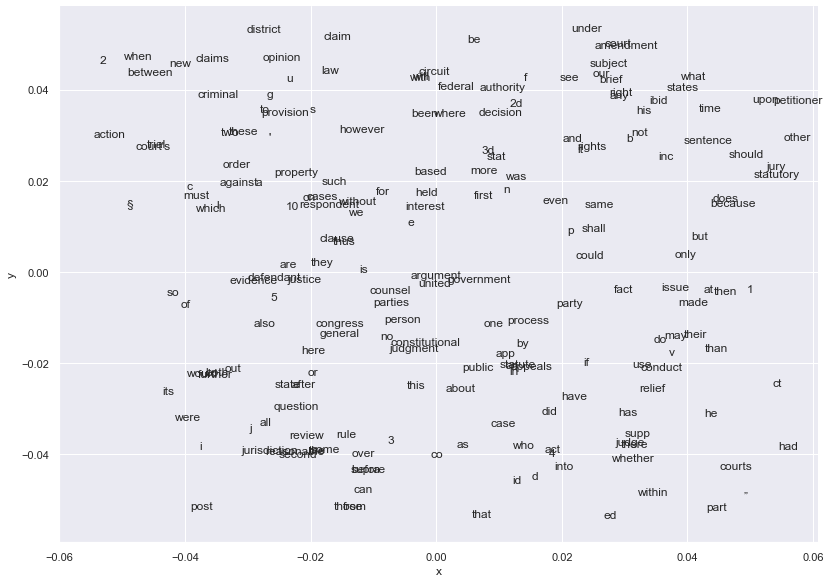

20/20 [==============================] - 0s 15ms/step - loss: 3.4298 - val_loss: 3.5648


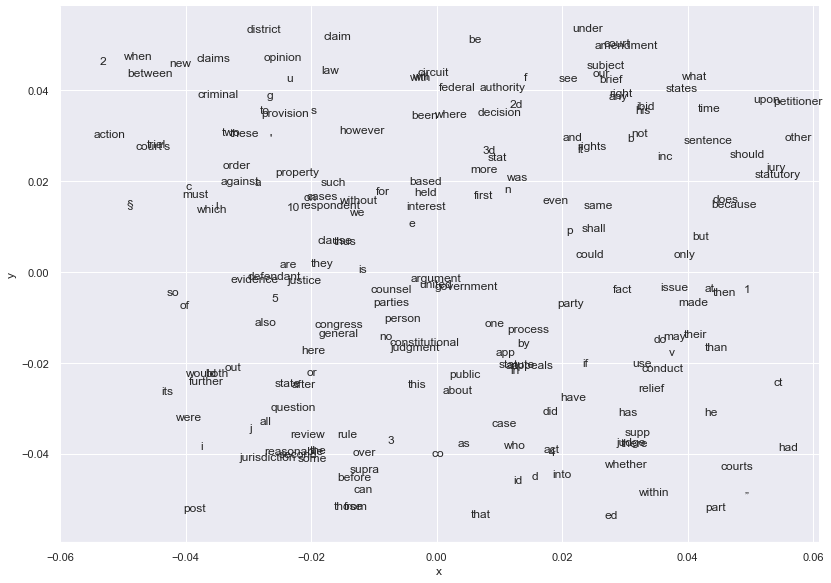

20/20 [==============================] - 0s 15ms/step - loss: 3.4296 - val_loss: 3.5648


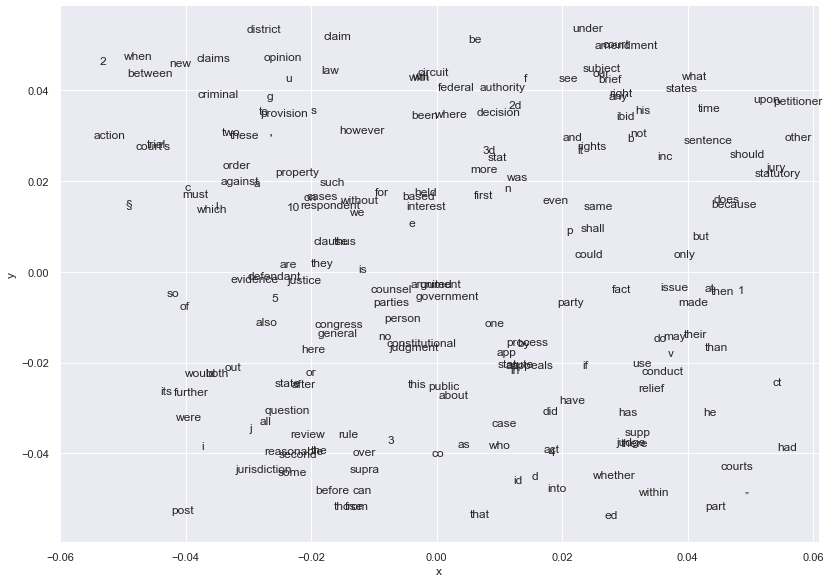

20/20 [==============================] - 0s 15ms/step - loss: 3.4293 - val_loss: 3.5648


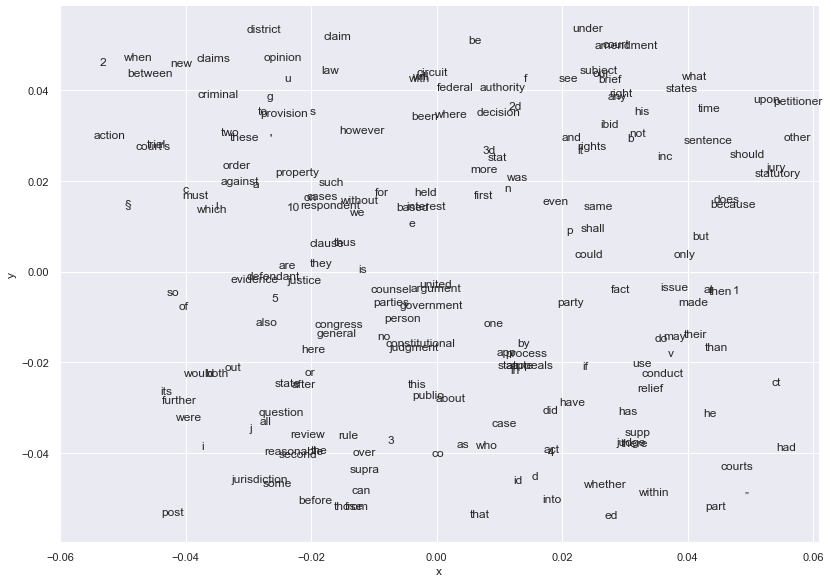

20/20 [==============================] - 0s 14ms/step - loss: 3.4290 - val_loss: 3.5648


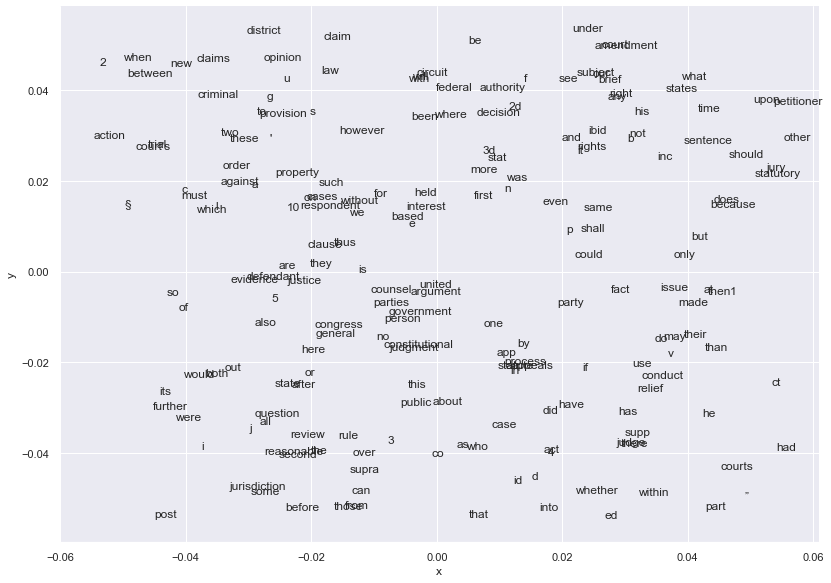

20/20 [==============================] - 0s 14ms/step - loss: 3.4289 - val_loss: 3.5648


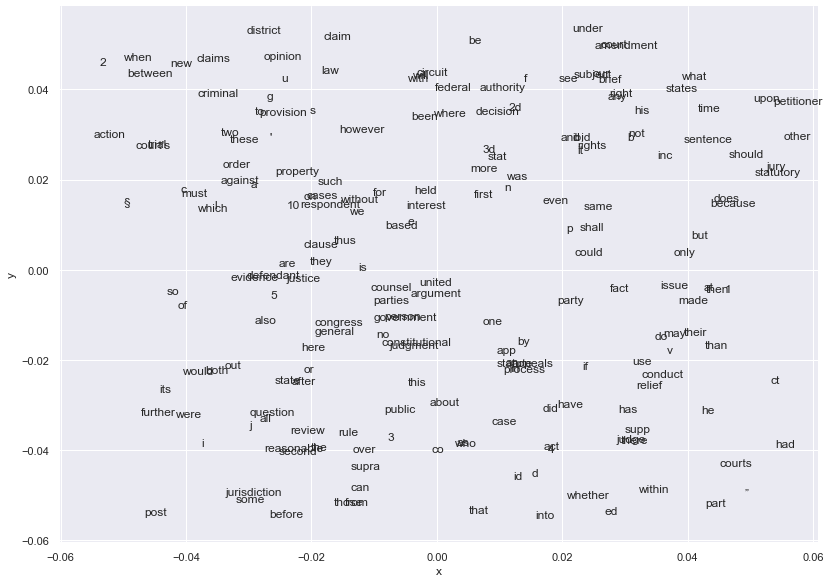

20/20 [==============================] - 0s 15ms/step - loss: 3.4287 - val_loss: 3.5648


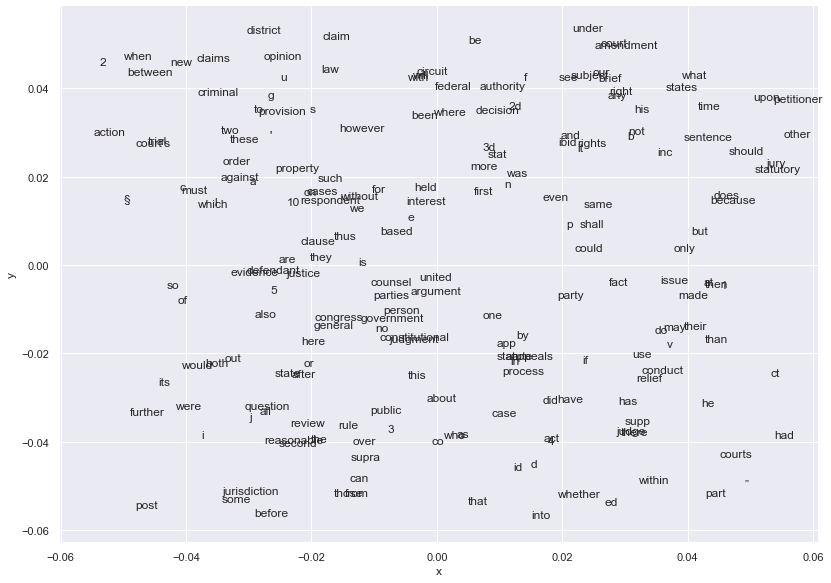

20/20 [==============================] - 0s 14ms/step - loss: 3.4285 - val_loss: 3.5648


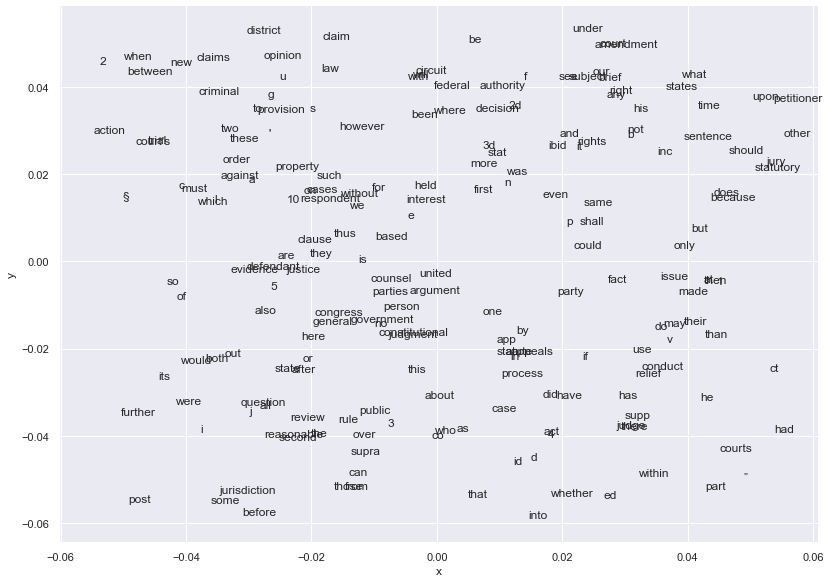

In [17]:
# show the vectors
from matplotlib import pyplot as plt

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(10):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)

    word_vectors = model.layers[0].get_weights()[0]
    df3['x'] = word_vectors[:,0]
    df3['y'] = word_vectors[:,1]

    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()


In [20]:
# Word Similarity
from scipy.spatial.distance import cosine

vec_defendants = word_vectors[tokenizer.word_index['defendant']-1]
vec_sent = word_vectors[tokenizer.word_index['sentence']-1]
vec_against = word_vectors[tokenizer.word_index['against']-1]

print(1-cosine(vec_defendants, vec_sent))

-0.8457629680633545


In [21]:
print(1-cosine(vec_defendants, vec_against))

0.8435810208320618


# Word2Vec in gensim

In [22]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 7.90361762e-02,  1.48321679e-02, -3.45855653e-02, -8.37420486e-03,
       -6.91372231e-02, -1.35109015e-03, -2.41043344e-02,  7.55759478e-02,
        3.17831524e-02, -4.98501472e-02,  1.53472545e-02, -7.86296055e-02,
        4.72505577e-02, -8.62817932e-03, -9.79289860e-02, -9.04591531e-02,
        8.84167030e-02,  1.17285259e-01,  3.23090032e-02,  2.27466691e-02,
        1.92940813e-02,  6.56933710e-02, -9.66858044e-02,  2.40980648e-02,
        9.20166373e-02, -5.25063463e-02,  9.06949490e-02, -2.03488991e-02,
        8.25824856e-04,  5.26381321e-02, -8.96067545e-03,  1.92172248e-02,
        6.97417110e-02,  2.18099713e-01,  4.08835895e-02,  1.99590642e-02,
        1.72007233e-02, -3.45626026e-02, -1.11437105e-01, -8.97553638e-02,
       -1.14782184e-01,  5.61040193e-02, -5.47497198e-02, -2.39778752e-03,
       -5.77222332e-02, -1.08734220e-02,  6.97485432e-02, -2.14979798e-02,
        3.15525495e-02, -4.84613776e-02, -6.46696463e-02, -1.40601525e-03,
        4.05100361e-02,  

In [23]:
w2v.wv.similarity('judg','juri') # similarity 

0.55676866

In [24]:
w2v.wv.most_similar('judg') # most similar words

[('bench', 0.595130205154419),
 ('juri', 0.5567686557769775),
 ('court', 0.5255749225616455),
 ('prosecutor', 0.5105170607566833),
 ('factfind', 0.49927276372909546),
 ('unanim', 0.49558883905410767),
 ('panel', 0.4932020604610443),
 ('erron', 0.48940056562423706),
 ('special', 0.4760306179523468),
 ('magistr', 0.47335782647132874)]

In [25]:
# word2vec requires sentences as input
from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower#.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words ]#if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

# train the model
from gensim.models import Word2Vec
w2v = Word2Vec(sentences,  # list of tokenized sentences
               workers = 8, # Number of threads to run in parallel
               size=300,  # Word vector dimensionality     
               min_count =  25, # Minimum word count  
               window = 5, # Context window size      
               sample = 1e-3, # Downsample setting for frequent words
               )

# done training, so delete context vectors
w2v.init_sims(replace=True)

w2v.save('w2v-vectors.pkl')

w2v.wv['judg'] # vector for "judge"

array([ 0.01660597, -0.014491  , -0.06466607,  0.00338004, -0.10166486,
       -0.03186716,  0.03267402,  0.08544654,  0.01586518, -0.06605083,
       -0.00133391, -0.02175051,  0.06845988, -0.10451567, -0.08820338,
       -0.03793775, -0.0055505 , -0.01427049, -0.02876893, -0.01859709,
        0.00857535,  0.04276068, -0.03236053,  0.03504349,  0.06495547,
        0.0766483 ,  0.05625184, -0.00827194,  0.08546019, -0.01612462,
        0.05973354, -0.02423955,  0.01825311,  0.11533827, -0.09713786,
       -0.02607737,  0.06668174,  0.09075166, -0.16446911,  0.15387398,
        0.02365528,  0.01818788, -0.02763686, -0.0637726 ,  0.01268513,
       -0.11656985, -0.0815101 , -0.00293737,  0.06036182,  0.02522556,
       -0.0089263 ,  0.03417287, -0.14313212,  0.06721326,  0.00270209,
       -0.00411543, -0.00865357, -0.00722206, -0.02877434,  0.01594872,
       -0.09082123,  0.11998541, -0.01082979,  0.00314174,  0.05648291,
       -0.02280653,  0.02390754,  0.00872231, -0.08508608, -0.02

In [26]:
w2v.wv.similarity('judg','juri') # similarity 

0.6517069

In [27]:
w2v.wv.most_similar('judg') # most similar words

[('judge,', 0.7913156151771545),
 ('juri', 0.651706874370575),
 ('jury,', 0.6450554132461548),
 ('prosecutor', 0.5994322896003723),
 ('judge.', 0.562285304069519),
 ('court', 0.5542303323745728),
 ('magistr', 0.551195502281189),
 ('juror', 0.5433478355407715),
 ('presid', 0.538032054901123),
 ('court,', 0.5145511627197266)]

In [28]:
# analogies: judge is to man as __ is to woman
w2v.wv.most_similar(positive=['judg','man'],
                 negative=['woman'])

[('judge,', 0.7053206562995911),
 ('jury,', 0.5669667720794678),
 ('juri', 0.5242562294006348),
 ('juror', 0.5018050670623779),
 ('prosecutor', 0.5000810623168945),
 ('magistr', 0.49856293201446533),
 ('admit', 0.4762115180492401),
 ('probat', 0.45938241481781006),
 ('error', 0.4483698606491089),
 ('defend', 0.44806671142578125)]

In [29]:
# Word2Vec: K-Means Clusters
from sklearn.cluster import KMeans
kmw = KMeans(n_clusters=50)
kmw.fit(w2v.wv.vectors)
judge_clust = kmw.labels_[w2v.wv.vocab['judg'].index]
for i, cluster in enumerate(kmw.labels_):
    if cluster == judge_clust and i<=100:
        print(w2v.wv.index2word[i])

his
he
defend


# Pre-trained vectors

In [ ]:
import spacy
en = spacy.load('en_core_web_sm')
apple = en('apple') 
apple.vector # vector for 'apple'

In [ ]:
apple.similarity(apple)

In [ ]:
orange = en('orange')
apple.similarity(orange)

In [ ]:
import spacy
#!python -m spacy download de_core_news_sm
de = spacy.load('de_core_news_sm')
apfel = de('apfel')
orange = de('orange')
apfel.similarity(orange)

In [ ]:
# Initializing an embedding layer with pre-trained vectors
embed_dims = len(apple.vector)
embedding_matrix = np.zeros([num_words, embed_dims])
for word, i in tokenizer.word_index.items():
    if i > num_words:
        break
    embedding_vector = en(word).vector
    embedding_matrix[i-1] = embedding_vector    

In [ ]:
model = Sequential()
model.add(Embedding(num_words,
                    embed_dims,
                    weights=[embedding_matrix],
                    input_length=maxlen,
                    trainable=False)) # frozen layer
model.add(Flatten()) # 86*300 = 25800 dims
model.add(Dense(64,activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
# show the vectors
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)

df3 = pd.DataFrame(list(tokenizer.word_index.items()),
                  columns=['word', 'word_index']).sort_values('word_index')[:num_words]

for i in range(3):
    if i > 0:
        model.fit(X,Y,epochs=1, validation_split=.2)
    
    word_vectors = model.layers[0].get_weights()[0]
    wv_tsne = tsne.fit_transform(word_vectors)

    df3['x'] = wv_tsne[:,0]
    df3['y'] = wv_tsne[:,1]
    plot = sns.relplot( data=df3, x="x", y="y", s=0, height=8.27, aspect=11.7/8.27)

    for row in df3.itertuples():
        ax = plot.axes[0, 0]
        ax.text(row.x, row.y, row.word, horizontalalignment='left')
    plt.show()

# GloVe

In [ ]:
#!pip install glove-python-binary for python >3.6
#!pip install glove_python for other versions

import itertools
from glove import Corpus, Glove

from nltk import sent_tokenize
from string import punctuation
translator = str.maketrans('','',punctuation) 
from nltk.corpus import stopwords
stoplist = set(stopwords.words('english'))
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer('english')

def normalize_text(doc):
    "Input doc and return clean list of tokens"
    doc = doc.replace('\r', ' ').replace('\n', ' ')
    lower = doc.lower() # all lower case
    nopunc = lower.translate(translator) # remove punctuation
    words = nopunc.split() # split into tokens
    nostop = [w for w in words if w not in stoplist] # remove stopwords
    no_numbers = [w if not w.isdigit() else '#' for w in nostop] # normalize numbers
    stemmed = [stemmer.stem(w) for w in no_numbers] # stem each word
    return stemmed

def get_sentences(doc):
    sent=[]
    for raw in sent_tokenize(doc):
        raw2 = normalize_text(raw)
        sent.append(raw2)
    return sent

sentences = []
for doc in df['opinion_text']:
    sentences += get_sentences(doc)
from random import shuffle
shuffle(sentences) # stream in sentences in random order

corpus = Corpus()
corpus.fit(sentences, window=10)
glove = Glove(no_components=100, learning_rate=0.05)

In [ ]:
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)

In [ ]:
glove.word_vectors[glove.dictionary['judg']]

In [ ]:
glove.most_similar('judg')


# Word Mover Distance

In [ ]:
import spacy
import wmd
nlp = spacy.load('en_core_web_sm', 
                 create_pipeline=wmd.WMD.create_spacy_pipeline)
doc1 = nlp("Politician speaks to the media in Illinois.")
doc2 = nlp("The president greets the press in Chicago.")
print(doc1.similarity(doc2))

# Embedding Lookup

Keras provides functionality to feed just words (actually indices of words) as model input. The model then performs an embedding lookup (we go from sparse one-hot to dense) which then becomes the input for further computation in the model. For a more detailed tutorial, have a look [here](https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/). 

First, we have to pre-process the data once again

In [ ]:
#df['opinion_text']

from keras.preprocessing.text import text_to_word_sequence

# tokenize the text


tokenized = [text_to_word_sequence(opinion) for opinion in df["opinion_text"]]
print (tokenized[0][:50])

In [ ]:
from collections import Counter
counter = Counter()
for i in tokenized:
        counter.update(i)
print (counter.most_common(10))
num_words = len(counter)
print (num_words) ## 58'787
print (max(len(i) for i in tokenized)) # 26'097, this is one of the challenges of working with legal text

In [ ]:
# create one_hot representation for each word
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
length_vocab = 10000
X_one_hot = [one_hot(opinion, n=length_vocab) for opinion in df["opinion_text"]]
print (X_one_hot[0][:50])

In [ ]:
# next, we pad (or truncate) such that all the inputs have same length

max_seq_length = 2000
X_one_hot_padded = pad_sequences(X_one_hot, padding='post', maxlen=max_seq_length, truncating='post')
X_one_hot_padded.shape # (768, 2000)

**Embedding lookup**

In [ ]:
from keras.layers import Embedding
from keras.models import Sequential

model = Sequential() # create a sequential model
model.add(Embedding(length_vocab, 64, input_length=max_seq_length, name="embedding_layer"))
model.summary() #640'000 params because 64 dim for 10'000 words

# that's it
